In [1]:
import os
import time
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import itertools
from torch.autograd import Variable
import sklearn, sklearn.model_selection, sklearn.metrics
import numpy as np

from models.model_wrapper import MLP, GCN, SLR
from data import datasets
from data.gene_graphs import GeneManiaGraph
from data.utils import record_result



In [2]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 1668 finished pieces out of 1668 total pieces.
Found dataset at /Users/martinweiss/.academictorrents-datastore/TCGA_tissue_ppi.hdf5
Converting one-hot labels to integers


In [3]:
# Setup the results dictionary
filename = "experiments/results/fig-5.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'num_genes', 'seed', 'train_size', 'time_elapsed'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [4]:
gene_graph = GeneManiaGraph()

Torrent name: genemania.pkl, Size: 9.61MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 294 finished pieces out of 294 total pieces.
Found dataset at /Users/martinweiss/.academictorrents-datastore/genemania.pkl


In [5]:
search_num_genes=[50, 100, 200, 300, 500, 1000]
test_size=1000
search_train_size=[50]
cuda=False
trials=5
search_genes = ["RPL4", "IL5", "CEBPD", ]#"RPL5", "RPS10", "RPS3",  "PABPC3", "PSMB10", "S100A8", "S100A9", "TOP1", "C15orf40", "RNF138", "DLGAP2", "EVI2B", "ZFP82", "MYBL2", "PSMB1", "CISD1", "HLA-B", "SAA2", "IFIT1", "RPS3A", "TP53", "TNF", "EGFR"]
model_list = [           
              GCN(name="GCN_lay20_chan32_emb32_dropout_pool_hierarchy", cuda=cuda, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="hierarchy"),
              GCN(name="GCN_lay20_chan32_emb32_dropout_pool_random", cuda=cuda, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="random"),
#               GCN(name="GCN_lay3_chan64_emb32_pool_hierarchy", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32, pooling="hierarchy"),
#               GCN(name="GCN_lay3_chan64_emb32_pool_random", cuda=cuda, dropout=True, num_layer=3, channels=64, embedding=32, pooling="random"),
              MLP(name="MLP_lay2_chan512_dropout", cuda=cuda, dropout=True, num_layer=2, channels=512),
              MLP(name="MLP_lay2_chan512", cuda=cuda, dropout=False, num_layer=2, channels=512),
              SLR(name="SLR_lambda1_l11", cuda=cuda)
             ]

In [6]:
# Create the set of all experiment ids and see which are left to do
model_names = [model.name for model in model_list]
columns = ["gene", "model", "num_genes", "train_size", "seed"]
all_exp_ids = [x for x in itertools.product(search_genes, model_names, search_num_genes, search_train_size, range(trials))]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")
print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 332
done: 1006


In [50]:
def get_every_n(a, n=2):
    for i in range(a.shape[0] // 2):
        yield a[2*i:2*(i+1)]

def bucket_weights(adj, bins):
    labels = ["".join(str(labels[0]) + "-" + str(round(labels[1], 1))) for labels in zip(bins, bins + 0.1)]
    labels[0] = "(" + labels[0]

    results = []
    nodes = {}
    for x in bins:
        subgraph = ((adj > x) & (adj <= x + 0.1))  
        results.append(subgraph.sum())
        nodes[x] = subgraph
    return results, labels, nodes


def show_degree(G):  
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
    pos = nx.spring_layout(G)
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.show()


In [43]:
gene="RPL3"

In [46]:
first_degree_neighbors = ""
for gene in gene_graph.nx_graph.nodes:
    first_degree_neighbors = set([n for n in gene_graph.nx_graph.neighbors(gene)])
    if len(list(first_degree_neighbors)) > 20 and len(list(first_degree_neighbors)) < 50:
        break
second_degree_neighbors = first_degree_neighbors.copy()
for gene in first_degree_neighbors:
    for second_gene in gene_graph.nx_graph.neighbors(gene):
        second_degree_neighbors.add(second_gene)
nx_graph = gene_graph.nx_graph.subgraph(second_degree_neighbors)

In [47]:
adj = np.asarray(nx.to_numpy_matrix(nx_graph))

In [48]:
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
results, labels, nodes = bucket_weights(adj, bins)

/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


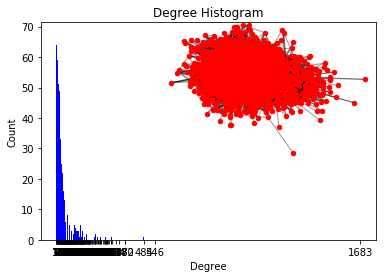

In [53]:
import collections
show_degree(nx_graph)

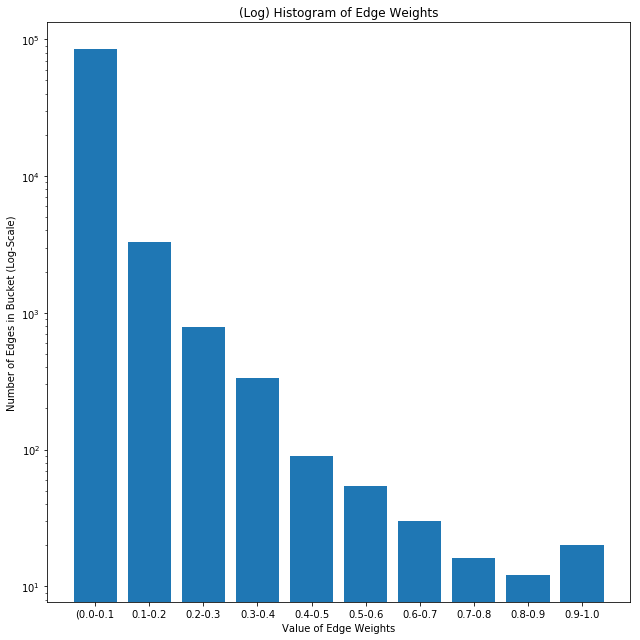

In [55]:
plt.figure(figsize=(9, 9))

plt.bar(x=labels, height=results, log=1)
plt.title("(Log) Histogram of Edge Weights")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket (Log-Scale)")
plt.xlim=1.0

plt.tight_layout()
plt.show()

In [ ]:
for row in todo:
    print(row)
    start_time = time.time()
    gene = row["gene"]
    model_name = row["model"]
    seed = row["seed"]
    num_genes = row["num_genes"]
    train_size = row["train_size"]

    model = [x for x in model_list if x.name == model_name][0]

    experiment = {
        "gene": gene,
        "model": model.name,
        "num_genes": num_genes,
        "train_size": train_size,
        "seed": seed,
    }

    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

    neighbors = gene_graph.bfs_sample_neighbors(gene, num_genes)

    X_train = X_train[list(neighbors.nodes)].copy()
    X_test = X_test[list(neighbors.nodes)].copy()
    X_train[gene] = 1
    X_test[gene] = 1
    adj = np.asarray(nx.to_numpy_matrix(neighbors))
    model.fit(X_train, y_train, adj=adj)
    
    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
    if cuda:
        x_test = x_test.cuda()
    
    y_hat = []
    for chunk in get_every_n(x_test, 10):
        y_hat.extend(model.predict(chunk)[:,1].data.cpu().numpy().tolist())
    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())

    del model
    experiment["auc"] = auc
    experiment["time_elapsed"] = str(time.time() - start_time)
    experiment["cuda"] = cuda
    results = record_result(results, experiment, filename)
    print("time elapsed for genes: " +str(num_genes) + " : " + str(time.time() - start_time))


{'model': 'GCN_lay20_chan32_emb32_dropout_pool_hierarchy', 'num_genes': 500, 'train_size': 50, 'seed': 0, 'gene': 'RPL4'}
time elapsed for genes: 500 : 29.863152027130127
{'model': 'GCN_lay20_chan32_emb32_dropout_pool_hierarchy', 'num_genes': 500, 'train_size': 50, 'seed': 1, 'gene': 'RPL4'}
time elapsed for genes: 500 : 28.837203979492188
{'model': 'GCN_lay20_chan32_emb32_dropout_pool_hierarchy', 'num_genes': 500, 'train_size': 50, 'seed': 2, 'gene': 'RPL4'}
time elapsed for genes: 500 : 26.624013900756836
{'model': 'GCN_lay20_chan32_emb32_dropout_pool_hierarchy', 'num_genes': 500, 'train_size': 50, 'seed': 3, 'gene': 'RPL4'}
time elapsed for genes: 500 : 25.26327896118164
{'model': 'GCN_lay20_chan32_emb32_dropout_pool_hierarchy', 'num_genes': 500, 'train_size': 50, 'seed': 4, 'gene': 'RPL4'}
time elapsed for genes: 500 : 33.459810972213745
{'model': 'GCN_lay20_chan32_emb32_dropout_pool_hierarchy', 'num_genes': 1000, 'train_size': 50, 'seed': 0, 'gene': 'RPL4'}
1.640855073928833
5.044

206


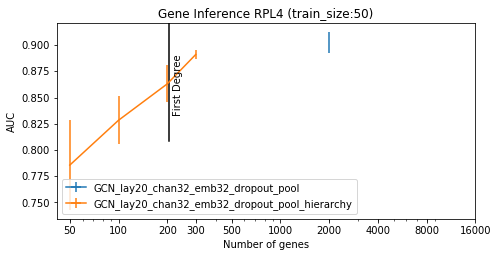

3


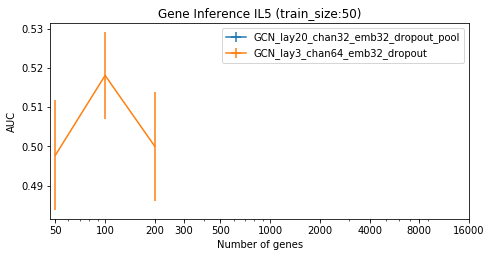

34


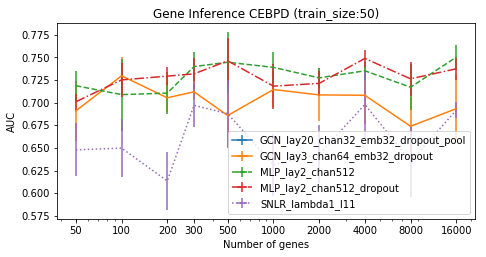

In [19]:

for plot_gene in search_genes:

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (7.5, 3.6)
    plot_train_size = 50

    subset = results[(results.train_size==plot_train_size) & 
                      (results.gene==plot_gene) & 
                      (results.num_genes!=400) &      
                      (results.model != "GCN_lay3_chan64_emb32") & 
                      (results.num_genes> 0)]


    q = subset.groupby(['model','num_genes'])['auc']

    todo = list(subset["model"].unique())
    linestyles = ['-', '-', '--', '-.', ':']
    for ls, model in enumerate(sorted(todo)):
        index = list(q.mean()[model].index)
        mean = q.mean()[model]
        stderr = q.std()[model]/np.sqrt(q.count()[model])
        displayname = model.replace("CGN","GCN")
        displayname = displayname.replace("SLR", "SNLR")
        plt.errorbar(index, mean, label=displayname, xerr=0, yerr=stderr, ls=linestyles[ls])

    plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
    plt.ylabel("AUC")
    plt.xlabel("Number of genes")
    plt.xscale("log")
    plt.xticks(sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter()
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.legend();
    fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
    print(fd)
    if fd > 50:
        plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
        c = plt.ylim()
        plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)


    plt.savefig("experiments/results/sgi-" + plot_gene + "-" + "train" + str(plot_train_size) + ".png", bbox_inches='tight')
    plt.show()